# STARDIST

Trying out how stardist works and setting it up to be run on full volumes on the cluster

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
from contextlib import redirect_stdout
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import tifffile as tiff
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

## Initializing Stardist 
1. Choosing model
2. Setting vars for it


In [2]:
demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model = StarDist2D(None, name='stardist', basedir='models')
None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.


Found model '2D_demo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


## Running the stardist model on a volume

### We need to look at the normalization step! 

### TODO: iterate over models

In [34]:
# vars set
# Stardist models:
# '2D_versatile_he' = needs 3 channels as input!

model_list = [ '2D_paper_dsb2018', '2D_versatile_fluo', '2D_demo' ]
axis_norm = (0, 1)
n_channel = 1

vol_path = '/users/niklas.khoss/stardist_test/one_volume.tif'

for mdl in model_list:
    
    # Setting correct working directory
    os.chdir('/users/niklas.khoss/stardist_test')

    # create output directory for each model
    out_dir = "./" + mdl
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    os.chdir(out_dir)
    
    # logging/redirecting stdout
    log_file = "./log_" + mdl + ".log"
    
    with open(log_file, 'w') as log:
        with redirect_stdout(log):

            # load stardist model
            model = StarDist2D.from_pretrained(mdl)

            # open volume.tif
            with tiff.TiffFile(vol_path) as vol:

                # iterate over images to run stardist on single images
                for idx, page in enumerate(vol.pages[1:]):

                    img = page.asarray()
                    print(idx, img.shape)

                    # normalizing images (stardist function)
                    img = normalize(img, 1, 99.8, axis=axis_norm)

                    # run the prediction
                    labels, details = model.predict_instances(img)
                    
                    # save labels as npy array
                    np_sv = "./mask_" + str(idx)
                    np.save(np_sv, labels, allow_pickle=True)

                    # plot the labels and overlay
                    plt.figure(figsize=(16,16))
                    plt.title("Z = " + str(idx) + " mask overlay")
                    plt.imshow(img)
                    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
                    plt.axis('off')
                    sv_fig = "overlay_" + str(idx) + ".png"
                    plt.savefig(sv_fig)
                    
                    # save the label image
                    label_sv = "labels_" + str(idx) + ".png"
                    plt.imsave(label_sv, labels, cmap=lbl_cmap)

                    # close image
                    plt.close()

#                     # plot cooler labels ()
#                     plt.figure(figsize=(48, 48))
#                     coord, points, prob = details['coord'], details['points'], details['prob']
#                     plt.subplot(121); plt.imshow(img, cmap='gray'); plt.axis('off')
#                     a = plt.axis()
#                     _draw_polygons(coord, points, prob, show_dist=True)
#                     plt.axis(a)
#                     plt.subplot(122)
#                     plt.imshow(img)
#                     plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
#                     plt.axis('off')                 


### Saving output
Save the results in a imageJ compatible manner

In [3]:
# save_tiff_imagej_compatible('example_image.tif', img, axes='YX')
# save_tiff_imagej_compatible('example_labels.tif', labels, axes='YX')


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
0 (700, 900)
labels:  (700, 900)
<class 'numpy.ndarray'>


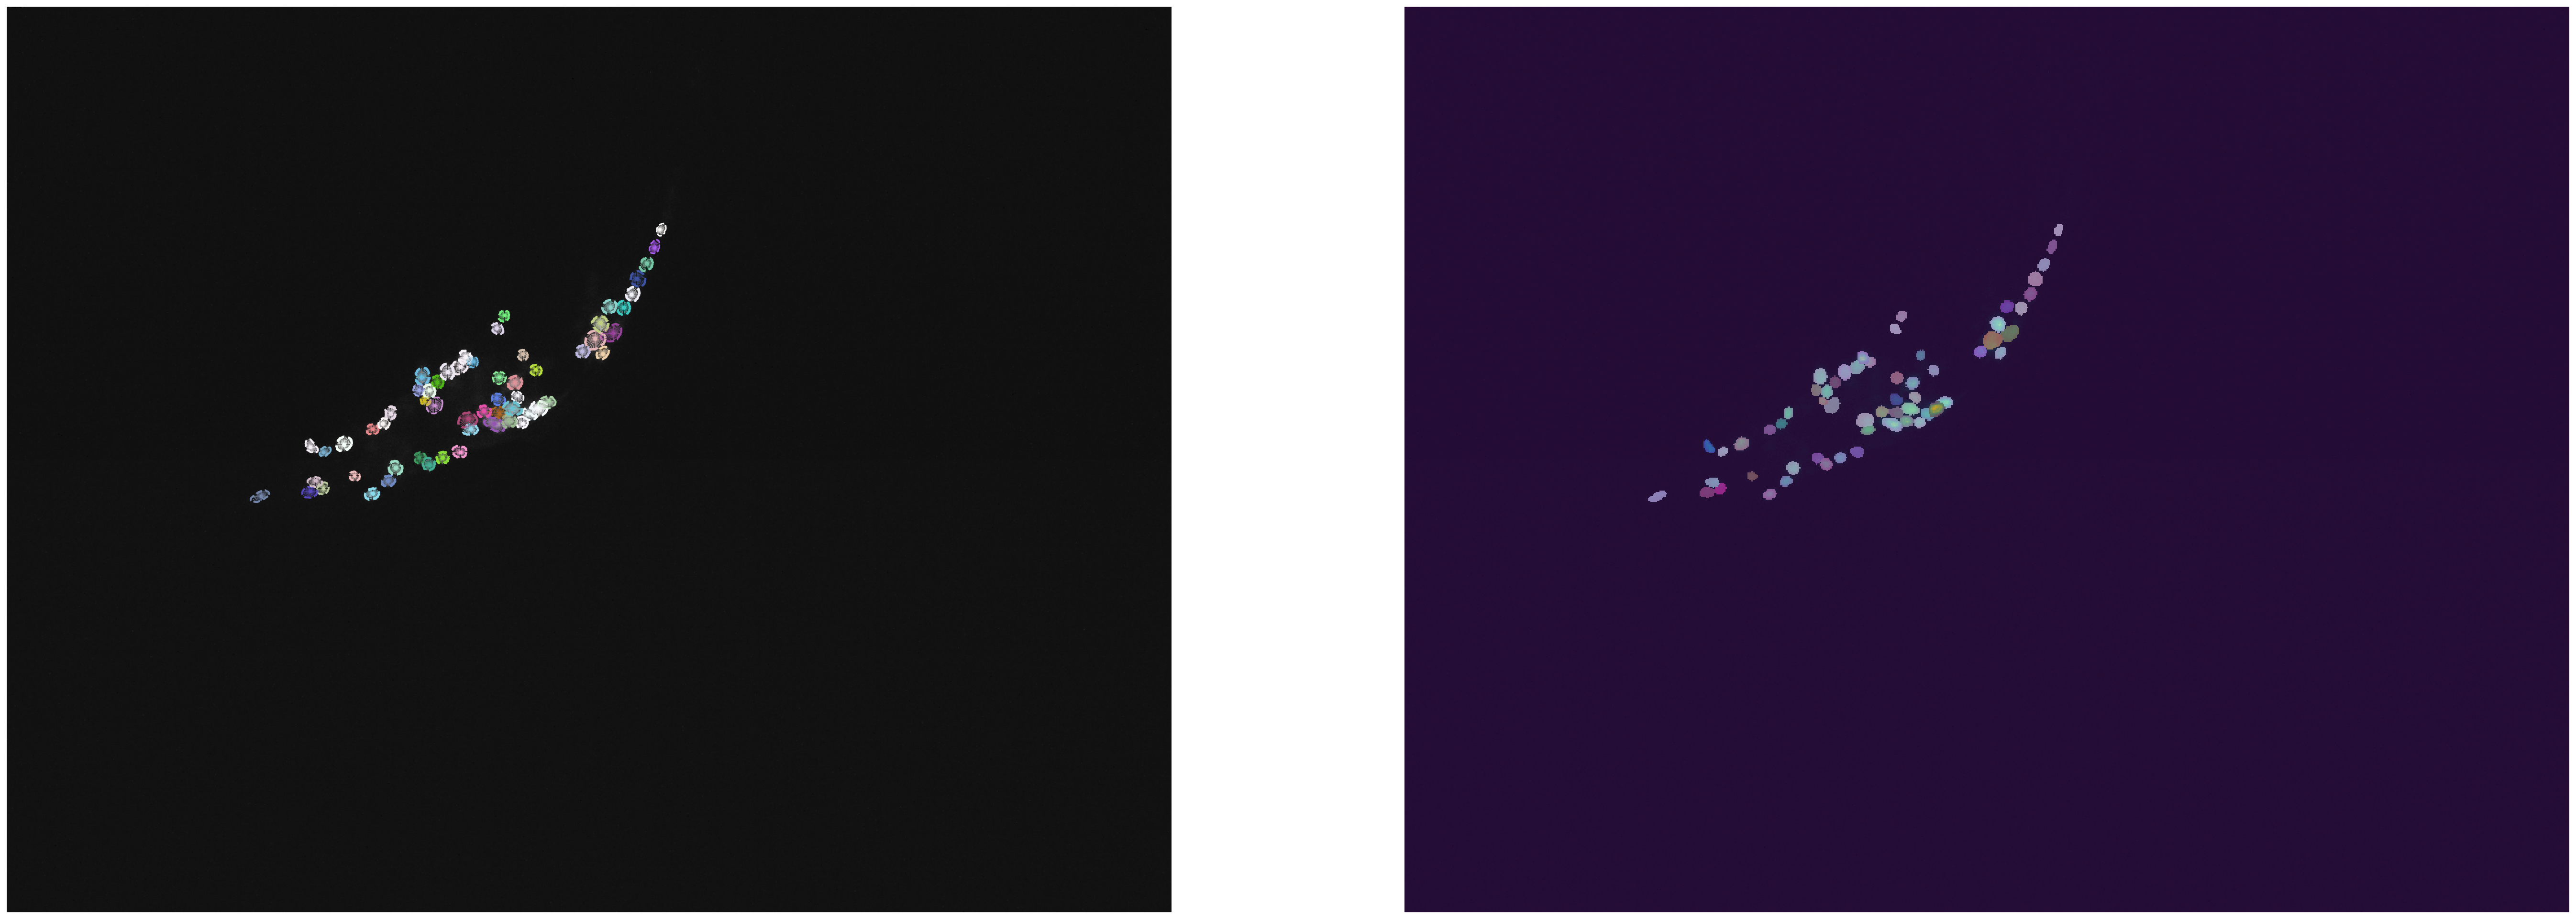

In [14]:
# 
axis_norm = (0, 1)
n_channel = 1
model = StarDist2D.from_pretrained('2D_versatile_fluo')
vol_path = '/users/niklas.khoss/stardist_test/one_volume.tif'

# open volume.tif
with tiff.TiffFile(vol_path) as vol:

    # iterate over images to run stardist on single images
    for idx, page in enumerate(vol.pages[13:14]):

        img = page.asarray()
        print(idx, img.shape)

        # normalizing images (stardist function)
        img = normalize(img, 1, 99.8, axis=axis_norm)

        # run the prediction
        labels, details = model.predict_instances(img)
        
        print('labels: ', labels.shape)
        print(type(labels))
        

        # plot the labels
#         plt.figure(figsize=(16,16))
# #                     plt.subplot(1,2,1)
# #                     plt.imshow(img)
# #                     plt.subplot(122)
# #                     plt.imshow(img)
#         plt.imshow(labels, cmap=lbl_cmap)    # alpha=0.5 taken out
#         plt.axis('off')
        
#         plt.imsave("./test1.png", labels, cmap=lbl_cmap, format='png')
#         plt.close()

        # plot cooler labels ()
        plt.figure(figsize=(48, 48))
        coord, points, prob = details['coord'], details['points'], details['prob']
        plt.subplot(121); plt.imshow(img, cmap='gray'); plt.axis('off')
        a = plt.axis()
        _draw_polygons(coord, points, prob, show_dist=True)
        plt.axis(a)
        plt.subplot(122)
        plt.imshow(img)
        plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
        plt.axis('off')
        plt.savefig('./cool_labels.png')

In [23]:
os.makedirs('test')

In [9]:
plt.savefig('./sd_result_example.png')

<Figure size 432x288 with 0 Axes>

In [12]:
os.chdir('/users/niklas.khoss/stardist_test/')